## Variational Auto-Encoder

Auto-Encoders are a family of methods to learn vectorial representations of data by means of a function $f$ that encodes some datum as a vector and a function $g$ which decodes such a vector back into a datum. Both functions can be trained by auto-encoding a data set, i.e. by ensuring that for all data $x$ in the data set, $g(f(x)) \approx x$. A basic challenge for auto-encoders is that the codes learned for the data do not necessarily generalize. In other words, if we sample code vectors $\vec z \in \mathbb{R}^k$ than $g(z)$ is not necessarily a realistic data point.

One of the most promising approaches to address this problem is the _variational auto-encoder_ by [Kingma and Welling (2014)](https://arxiv.org/abs/1312.6114) (better explained in this Tutorial by [Doersch, 2016](https://arxiv.org/abs/1606.05908)). It embeds the auto-encoding setup in a Bayesian framework as follows.

First, we re-frame our encoder and decoder in terms of probability distributions. In particular, we define one probability density $q(\vec z|x)$ which models the probability of a code vector $\vec z$ for a given datum $x$, i.e. our encoder, and we define a probability distribution $p(x|\vec z)$ which models the probability of a datum $x$ given a code vector $\vec z$, i.e. our decoder. Our overall aim will be to learn $p$ and $q$ such that the likelihood of our data $p(x)$ is maximized. But we return to that aim later.

Next, we assume that the code vectors $\vec z \in \mathbb{R}^k$ are distributed according to a simple, isotropic Gaussian, i.e. $p(\vec z) = \mathcal{N}(\vec z | \vec 0, I^k)$. Note that this assumption does not restrict the expressiveness of our model because we can still represent arbitrarily complex data via these codes, as long as the encoder and decoder are sufficiently powerful.

Next, we consider the 'true' conditional density of code vectors given inputs $p(\vec z | x)$. Ideally, our encoding density $q$ should approximate this density. To express how well $q$ performs that job, we can consider the Kullback-Leibler divergence between $q$ and $p$, which is given as follows:

\begin{equation}
D_\text{KL}\Big( q(\vec z| x) \Big|\Big| p(\vec z | x) \Big)
= \int q(\vec z| x) \cdot \Big( \log[q(\vec z| x)] - \log[p(\vec z| x)]\Big) d\vec z
\end{equation}

By virtue of Bayes' theorem we obtain:

\begin{equation}
p(\vec z | x) = \frac{p(x | \vec z) \cdot p(\vec z)}{p(x)}
\end{equation}
such that we can re-write the Kullback-Leibler divergence to:
\begin{align}
D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z | x) \Big)
&= \int q(\vec z| x) \cdot \Big(\log[q(\vec z| x)] - \log[p(x | \vec z)] - \log[p(\vec z)] + \log[p(x)] \Big) d\vec z \Big) \\
&= -\int q(\vec z| x) \cdot \log[p(x | \vec z)] d\vec z + \underbrace{\int q(\vec z| x) \cdot \Big(\log[q(\vec z| x)] -  \log[p(\vec z)]\Big) d\vec z}_{=D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z) \Big)} + \log[p(x)] \cdot \underbrace{\int q(\vec z| x) d\vec z}_{=1} \\
&= -\int q(\vec z| x) \cdot \log[p(x | \vec z)] d\vec z + D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z) \Big) + \log[p(x)]
\end{align}

We can rearrange this equation and obtain:

\begin{equation}
\log[p(x)] - D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z | x) \Big)
= \int q(\vec z| x) \cdot \log[p(x | \vec z)] d\vec z - D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z) \Big)
\end{equation}

In other words: If we have a $q(\vec z|\vec x)$ that approximates $p(\vec z | x)$ well enough and thus $D_\text{KL}\Big( q(\vec z|\vec x) \Big|\Big| p(\vec z | x) \Big) \approx 0$, then we can maximize the log-likelihood of our data $\log[p(x)]$ by maximizing the right-hand-side of our equation. More precisely, given a set of examples $\{x_1, \ldots, x_m\}$ from some domain $\mathcal{X}$, we wish to maximize the empiric log-likelihood of this data set, which can be re-written as follows:

\begin{equation}
\log[p(x_1, \ldots, x_m)] \stackrel{i.i.d.}{=} \sum_{i=1}^m \log[p(x_i)]
\geq \sum_{i=1}^m \int q(\vec z| x_i) \cdot \log[p(x_i | \vec z)] d\vec z - D_\text{KL}\Big( q(\vec z|\vec x_i) \Big|\Big| p(\vec z) \Big)
\end{equation}
Maximizing this right-hand side is still not completely feasible due to the integral. Therefore, we simplify matters even further by sampling a single code vector $\vec z_i$ for each datum $x_i$ according to our current density $q(\vec z|x_i)$ and compute the log likelihood for this code vector. In other words, we obtain the minimization problem:
\begin{equation}
\min_{q, p} -\sum_{i=1}^m \log[p(x_i | \vec z_i)] + D_\text{KL}\Big( q(\vec z_i|\vec x_i) \Big|\Big| \mathcal{N}(\vec z_i|\vec 0, I^k)\Big)
\end{equation}
This can be optimized via techniques like stochastic gradient descent, if we find a parametrization for our encoder and decoder distributions $q$ and $p$.

Since the marginal distribution for the code vectors $\vec z$ is supposed to be Gaussian, it stands to reason that the conditional distribution $q$ should also be Gaussian. A Gaussian is paramatrized by its mean and covariance matrix. So we have a deterministic encoder function $f : \mathcal{X} \to \mathbb{R}^k \times \mathbb{R}^{k \times k}$ which maps each data point $x \in \mathcal{X}$ to a most likely encoding $\vec \mu(x) := f_1(x)$ and a covariance matrix $\Sigma(x) := f_2(x)$. The distribution $q$ is then given as:

\begin{equation}
q(\vec z|x) := \mathcal{N}\big(\vec z\big|\vec \mu(x), \Sigma(x)\big) = \frac{1}{\sqrt{2\pi \cdot \det\big(\Sigma(x)\big)}} \cdot \exp\Big(-\frac{1}{2} \cdot [\vec z - \vec \mu(x)]^T \cdot \Sigma(x)^{-1} \cdot [\vec z - \vec \mu(x)]\Big)
\end{equation}

In this case, the Kullback-Leibler divergence between $q$ and the simple isotropic Gaussian is given as:

\begin{equation}
D_\text{KL}\Big( q(\vec z_i|\vec x_i) \Big|\Big| \mathcal{N}(\vec z_i|\vec 0, I^k)\Big)
= \frac{1}{2} \cdot \Big( \mathrm{tr}\big(\Sigma(x)\big) + \vec \mu(x)^T \cdot \vec \mu(x) - k - \log\big[\det\big(\Sigma(x)\big)\big]\Big)
\end{equation}

How we best define $p$ depends on the kind of data we are dealing with. In this tutorial, we will focus on simple, $n$-dimensional vectors, i.e. $\mathcal{X} = \mathbb{R}^n$. In that case, we can use an $n$-dimensional Gaussian to model $p$, where the mean is given by a deterministic decoder $g : \mathbb{R}^k \to \mathcal{X}$ and the covariance matrix is $\lambda^2 \cdot I$ where $\lambda$ is a hyper-parameter. More precisely:

\begin{equation}
p(\vec x | \vec z) := \mathcal{N}\big(\vec x\big|g(\vec z), \lambda^2 \cdot I^n\big) = \frac{1}{\sqrt{2\pi \cdot \lambda^{2n}}} \cdot \exp\Big(-\frac{1}{2\cdot \lambda^2} \cdot [\vec x - g(\vec z)]^T \cdot [\vec x - g(\vec z)]\Big)
\end{equation}

In this case, we can re-write our minimization problem to:

\begin{equation}
    \min_{f, g} \frac{m}{2} \log[2\pi] + \frac{m\cdot n}{2} \log[\lambda^2] + \frac{1}{2} \cdot \sum_{i=1}^m \frac{1}{\lambda^2} \cdot [\vec x_i - g(\vec z_i)]^T \cdot [\vec x_i - g(\vec z_i)] + \mathrm{tr}\big(\Sigma(\vec x_i)\big) + \vec \mu(\vec x_i)^T \cdot \vec \mu(\vec x_i) - k - \log\big[\det\big(\Sigma(\vec x_i)\big)\big]
\end{equation}

Note that $\frac{m}{2} \log[2\pi] + \frac{m\cdot n}{2} \log[\lambda^2]$ is a constant which we can ignore. As such, our problem is already much simpler: We basically have a squared loss between the original data point $\vec x_i$ and its auto-encoded version $g(\vec z_i)$ with some regularization term.

The last problem we have to tackle is that $\vec z_i$ actually depends on $\vec x_i$, because we sample $\vec z_i$ from $q$ and $q$ is conditioned on $\vec x_i$. To make this dependency explicit, we can use a simple trick: Because $q$ is Gaussian, sampling from it is equivalent to sampling from an isotropic Gaussian with zero mean, multiplying that with $\Sigma(\vec x_i)^{\frac{1}{2}}$ and adding the mean of $q$, i.e. $\vec \mu(\vec x_i)$. In other words, we obtain:
\begin{equation}
\vec z_i = \vec \mu(\vec x_i) + \Sigma(\vec x_i)^{\frac{1}{2}} \cdot \vec \epsilon_i \qquad \text{where } \vec \epsilon_i \sim \mathcal{N}(\vec \epsilon|\vec 0, I^k)
\end{equation}

Thus, our final form is:

\begin{equation}
    \min_{f, g} \frac{1}{2} \cdot \sum_{i=1}^m \frac{1}{\lambda^2} \cdot \lVert \vec x_i - g\big(\vec \mu(\vec x_i) + \Sigma(\vec x_i)^{\frac{1}{2}} \cdot \vec \epsilon_i\big) \rVert^2 + \mathrm{tr}\big(\Sigma(\vec x_i)\big) - k + \lVert \mu(\vec x_i) \rVert^2 - \log\big[\det\big(\Sigma(\vec x_i)\big)\big]
\end{equation}

So what we're _actually_ doing is just to train $f$ and $g$ such that $\vec x_i$ gets as close as possible to $g(f(\vec x_i))$, even if we disturb the encoding with Gaussian noise, with a regularization term that limits the Euclidean norm of all code vectors as well as the uncertainty for all code vectors.

### Sine Example

In our example, we use a very simple data set that is generated from a one-dimensional latent variable which we hope to recover via the auto-encoder. In particular, we generate $n$-dimensional vectors as sine waves with varying wave length $\tau = \frac{1}{z^2} \in \mathbb{R}$, where $z$ is sampled from $\mathcal{N}(\tau|0, 1)$. In other words, the vectors $\vec x \in \mathbb{R}^n$ are generated as
\begin{equation}
\vec x = \Big( \sin(2\pi \cdot \frac{0}{\tau}), \ldots, \sin(2\pi \cdot \frac{n-1}{\tau}) \Big)^T + \vec \nu
\qquad \text{where } \vec \nu \sim \mathcal{N}(\vec \nu|\vec 0, \rho^2 \cdot I^n)
\end{equation}

Unfortunately, our auto-encoder is unable to learn the one-dimensional latent structure _precisely_. To make learning feasible, we need to provide at least another latent dimension (i.e. $k = 2$). Still, we keep our model simple by limiting the covariance matrix $\Sigma(\vec x)$ to a diagonal matrix with the diagonal entries $\vec \sigma^2(\vec x) = \big(\sigma^2_1(\vec x), \ldots, \sigma^2_k(\vec x)\big)^T$. Our minimization problem thus simplifies to:

\begin{equation}
    \min_{f, g} \frac{1}{2} \cdot \sum_{i=1}^m \frac{1}{\lambda^2} \cdot \lVert \vec x_i - g\big(\mu(\vec x_i) + [\sqrt{\vec \sigma^2(\vec x_i)} \odot \vec \epsilon_i]\big) \rVert^2 + \sum_{j=1}^k \Big[\sigma^2_j(\vec x_i) - \log\big[\sigma^2_j(\vec x_i)\big]\Big] + \lVert\mu(\vec x_i)\rVert^2 - k
\end{equation}

As functions $f$ and $g$ we use two-layer feedforward neural networks with $L$ hidden units and logistic transfer function each.

In [130]:
# First, we define our encoder and decoder neural networks.
# Note that our code is strongly inspired by David Kingma's reference
# example: https://github.com/pytorch/examples/blob/master/vae/main.py

import torch

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_hid, dim_code = 1):
        # In the constructor, we first call the constructor
        # for a general neural network module
        super(Encoder, self).__init__()
        # Store the dimensionalities
        self.dim_in = int(dim_in)
        self.dim_hid = int(dim_hid)
        self.dim_code = int(dim_code)
        # Then we set up a neural network to map
        # the input via a hidden layer to the mean and
        # variance for the encoded vector.

        # First a linear layer
        self.hidden_layer = torch.nn.Linear(self.dim_in, self.dim_hid)
        # We apply a sigmoid layer after that
        self.sigmoid = torch.nn.Sigmoid()
        # And finally we apply another linear layer with two outputs.
        self.output_layer = torch.nn.Linear(self.dim_hid, 2*self.dim_code)
    
    def forward(self, X):
        # this computes the forward pass for our encoder, generating
        # two outputs for every input.
        H = self.sigmoid(self.hidden_layer(X))
        Y = self.output_layer(H)
        # take the first columns as means, the remaining columns as standard deviations
        Mu = Y[:, 0:self.dim_code]
        Sigma2 = Y[:, self.dim_code:]
        return (Mu, Sigma2)

class Decoder(torch.nn.Module):
    def __init__(self, dim_in, dim_hid, dim_code = 1):
        # In the constructor, we first call the constructor
        # for a general neural network module
        super(Decoder, self).__init__()
        # Store the dimensionalities
        self.dim_in = int(dim_in)
        self.dim_hid = int(dim_hid)
        self.dim_code = int(dim_code)
        # Then we set up a neural network to map
        # the code vector via a hidden layer to the decoded vector

        # First a linear layer
        self.hidden_layer = torch.nn.Linear(self.dim_code, self.dim_hid)
        # We apply a sigmoid layer after that
        self.sigmoid = torch.nn.Sigmoid()
        # And finally we apply another linear layer with n outputs
        self.output_layer = torch.nn.Linear(self.dim_hid, self.dim_in)

    def forward(self, Z):
        # this computes the forward pass for our decoder, generating
        # an dim_in dimensional vector for every input
        H = self.sigmoid(self.hidden_layer(Z))
        X = self.output_layer(H)
        return X

# We combine both into an auto-encoder model
class AutoEncoder(torch.nn.Module):
    def __init__(self, dim_in, dim_hid, dim_code = 1):
        # In the constructor, we first call the constructor
        # for a general neural network module
        super(AutoEncoder, self).__init__()
        # Store the dimensionalities
        self.dim_in = int(dim_in)
        self.dim_hid = int(dim_hid)
        self.dim_code = int(dim_code)
        # Initialize an en- and a decoder
        self.encoder = Encoder(self.dim_in, self.dim_hid, self.dim_code)
        self.decoder = Decoder(self.dim_in, self.dim_hid, self.dim_code)

    def forward(self, X):
        # first, get the means and variances for the codes of our
        # input
        (Mu, Sigma) = self.encoder(X)
        # then, sample random noise from a standard normal distribution
        epsilons = torch.randn_like(Mu)
        # re-scale and shift the noise to transform it to codes, sampled
        # from q(z|x)
        Z = (epsilons * Sigma).add_(Mu)
        # then, decode the code vectors
        X_decoded = self.decoder(Z)
        return (X_decoded, Mu, Sigma)

In [131]:
# Next, we need to define the loss function.

lambda2 = 1

def loss_function(X, X_decoded, Mu, Sigma):
    Sigma2 = Sigma.pow(2)
    # The first error term is just the squared error between
    # the original Xs and the decoded Xs, divided by the hyper-parameter lambda^2
    reconstruction_loss = torch.nn.functional.mse_loss(X_decoded, X, reduction='sum') / lambda2
    # The second error term is the Kullback-Leibler divergence between the
    # code distributions and the standard normal distribution
    KLD = torch.sum(Sigma2 + Mu.pow(2) - torch.log(Sigma2)) - X.size()[0]
    # add these terms and divide by 2
    return (reconstruction_loss + KLD) * 0.5

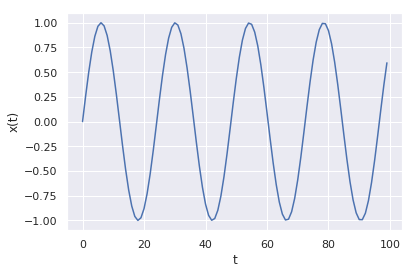

In [132]:
# Next, we define a function to generate training data at will
import math

def generate_data(m, n):
    # first, draw frequencies from a uniform distribution
    max_waves = 5
    min_waves = 1
    F = (torch.rand(m, 1) * (max_waves - min_waves) + min_waves) * 2 * math.pi / n
    # Then, generate the range 0 ... n-1
    steps = torch.arange(n).float()
    # Via the outer product, we generate the matrix X with entries F[i] * steps[t]
    # for all i and t
    steps = steps.unsqueeze(0)
    X = F.mm(steps)
    # We obtain the desired sine waves by taking the sine of each entry, after multiplying with 2pi
    X = torch.sin(X)
    return X

# Plot an example curve
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except:
    pass
ts = list(range(0, 100))
sine = generate_data(1, 100)[0]
plt.plot(ts, list(sine))
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()
%matplotlib inline

In [133]:
# Set up the training setting
# The number of sine curves in each minibatch
m = 50
# The length of each curve (= input dimensionality)
n = 100
# The number of hidden neurons
L = 2*n
# The number of dimensions for the code vectors
k = 2

# Initialize an auto-encoder
auto_enc = AutoEncoder(n, L, k)

# As optimizer, we use Adam
optimizer = torch.optim.Adam(auto_enc.parameters(), lr=0.01)

# We learn until our error is below a certain threshold
thresh = m * n * 1E-2

# We also accumulate the losses in each time step
learning_curve = []

In [134]:
# Start the learning itself
while(not learning_curve or learning_curve[-1] > thresh):
    # Generate a minibatch of data
    X = generate_data(m, n)
    # perform the forward computation of the model for the data to obtain the loss
    X_decoded, Mu, Sigma2 = auto_enc(X)
    # compute the loss and store it; note that the loss is an object
    # which we will also need to compute the gradient
    loss_object = loss_function(X, X_decoded, Mu, Sigma2)
    learning_curve.append(loss_object.item())

    # print the loss every 500 steps
    if(len(learning_curve) % 500 == 0):
        print('loss after {} steps: {}'.format(len(learning_curve), learning_curve[-1]))

    # A special feature of PyTorch is that we need to zero the gradients
    # in the optimizer at any point to ensure that past computations do
    # not influence the present ones
    optimizer.zero_grad()

    # compute the gradient of the loss
    loss_object.backward()

    # compute a step of the optimizer
    optimizer.step()

loss after 500 steps: 929.012939453125
loss after 1000 steps: 948.7941284179688
loss after 1500 steps: 654.8441772460938
loss after 2000 steps: 460.4119873046875
loss after 2500 steps: 565.655517578125
loss after 3000 steps: 453.34222412109375
loss after 3500 steps: 824.22412109375
loss after 4000 steps: 867.9368896484375
loss after 4500 steps: 855.50390625
loss after 5000 steps: 931.8430786132812
loss after 5500 steps: 1098.65625
loss after 6000 steps: 1077.9970703125
loss after 6500 steps: 713.32421875
loss after 7000 steps: 763.6446533203125
loss after 7500 steps: 712.623291015625
loss after 8000 steps: 623.1632080078125
loss after 8500 steps: 629.7630615234375
loss after 9000 steps: 506.95916748046875
loss after 9500 steps: 912.7233276367188
loss after 10000 steps: 943.17919921875
loss after 10500 steps: 996.2479248046875
loss after 11000 steps: 589.95556640625
loss after 11500 steps: 990.24560546875
loss after 12000 steps: 650.1666259765625
loss after 12500 steps: 769.635559082031

KeyboardInterrupt: 

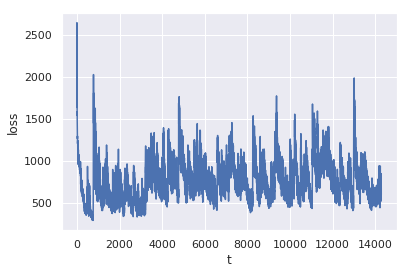

In [135]:
# plot the learning curve

import matplotlib.pyplot as plt

plt.plot(list(range(len(learning_curve))), learning_curve)
plt.xlabel('t')
plt.ylabel('loss')
plt.show()

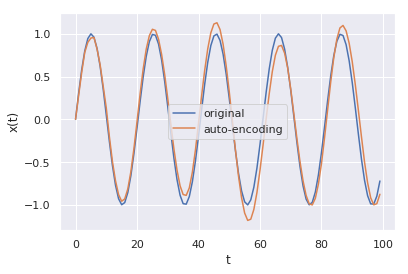

In [147]:
# Plot the original and the auto-encoded signal for an example
x = generate_data(1, n)
x_decoded, _, _ = auto_enc(x)
plt.plot(list(range(n)), list(x[0,:]), list(range(n)), list(x_decoded[0,:]))
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(['original', 'auto-encoding'])
plt.show()

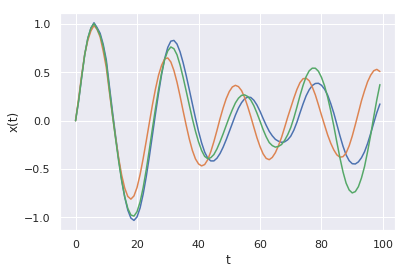

In [153]:
# Sample from the marginal code distribution and show a few generated curves
Z = torch.randn(3, k)
X = auto_enc.decoder(Z)
plt.plot(list(range(n)), list(X[0,:]), list(range(n)), list(X[1,:]), list(range(n)), list(X[2,:]))
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()


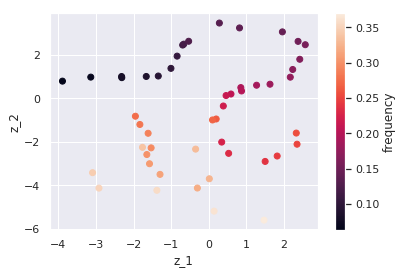

In [156]:
# Try to get a glimpse of the structure of the code space.
# To that end we first generate a range of frequencies in ascending
# order, from 1 wave to 6 waves within n.
F = torch.arange(1,6,0.1).unsqueeze(1) * 2 * math.pi / n
# Then, generate the range 0 ... n-1
steps = torch.arange(n).float()
# Via the outer product, we generate the matrix X with entries F[i] * steps[t]
# for all i and t
steps = steps.unsqueeze(0)
X = F.mm(steps)
# We obtain the desired sine waves by taking the sine of each entry, after multiplying with 2pi
X = torch.sin(X)
# Now, encode the sine waves
Z, _ = auto_enc.encoder(X)
# And plot the codes
sc = plt.scatter(Z[:,0].detach().numpy(), Z[:,1].detach().numpy(), c=list(F))
plt.xlabel('z_1')
plt.ylabel('z_2')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('frequency')
plt.show()